# Прогнозирование оттока клиентов в фитнес-клубе

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Необходимо провести анализ и подготовить план действий по удержанию клиентов.
А именно:

1) научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

2) сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

3) проанализировать основные признаки, наиболее сильно влияющие на отток;

4) сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
- выделить целевые группы клиентов;
- предложить меры по снижению оттока;
- определить другие особенности взаимодействия с клиентами.

### План выполнения проекта

[Шаг 1. Открытие файла с данными и изучение общей информации](#step1)

[Шаг 2. Исследовательский анализ данных (EDA)](#step2)

[Шаг 3. Модель прогнозирования оттока пользователей](#step3)

[Шаг 4. Кластеризация пользователей](#step4)

[Шаг 5. Выводы и базовые рекомендации по работе с клиентами](#step5)

## <a id="step1">Шаг 1. Открытие файла с данными и изучение общей информации </a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv', sep=',')
gym_churn.sample(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1274,0,1,1,1,1,12,0,33,95.795551,7.0,1,3.482456,3.539166,0
1641,0,1,1,1,1,12,0,32,143.579992,12.0,3,1.112927,1.202012,0
468,1,1,0,1,0,6,1,32,150.364048,3.0,2,1.650823,1.650317,0


In [3]:
#приведем названия столбцов к нижнему регистру
gym_churn.columns = gym_churn.columns.str.lower()

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
gym_churn.duplicated().sum()

0

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. В полученном датасете 4000 строк и 14 столбцов(13 признаков и одна целевая переменная - churn/отток), данные не требуют дополнительной обработки, типы данных соответсвуют признакам, нет ни пропусков ни дубликатов. Названия столбцов для удобства были приведены к нижнему регистру

Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:

- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## <a id="step2">Шаг 2. Исследовательский анализ данных (EDA) </a>

In [6]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Пропусков нет. Отсутствующие признаки не выявлены. Стандартное отклонение в большинстве случаев меньше среднего, а значит данные более или менее однородны. 

Из представленной таблицы мы видим, что:
- среди клиентов фитнес-центра примерно поровну мужчин и женщин,
- большинство живёт или работает недалеко от спортзала,
- почти половина пришли в фитнес центр по партнёрской программе, 
- 90% оставили номер своего мобильного телефона,
- средняя продолжительность контракта 4,7 месяца (большинство контрактов на 1 месяц, далее по популярности полугодовой контракт и наименее популярны контракты на 12 месяцев),
- групповые занятия посещали 41% пользователей,
- средний возраст 29 лет (большинство клиентов в возрасте 27-31),
- средняя выручка от прочих услуг фитнес центра 147 рублей,
- в среднее количество месяцев до завершения контракта 4,
- клиенты уже пользуются услугами фитнес-центра в среднем 3,7 месяца,
- частота посещений немного упала за последний месяц (в среднем 1,8 раз в неделю против 1,9 раз в среднем за весь период),
- отток составил 26,5%.

In [7]:
gym_churn.groupby('churn').agg('mean').round(2).T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Из средних значений можно сделать вывод, что люди, попавшие в категорию "отток", перестают ходить в зал примерно через месяц. Об этом свидетельствуют средние значения в колонках lifetime и month_to_end_contract.

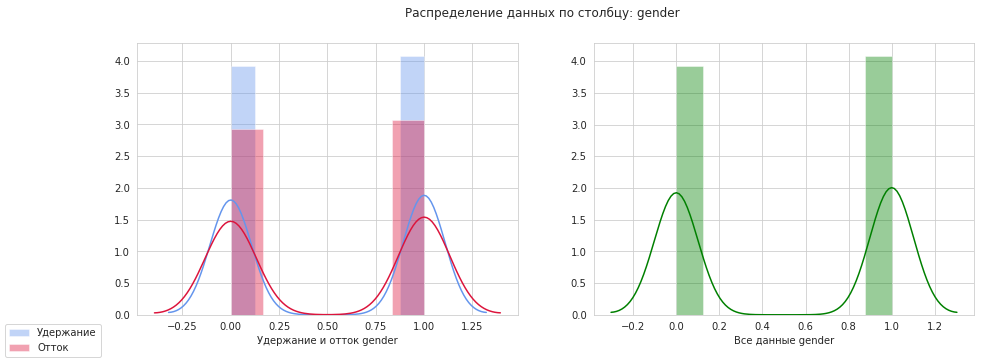

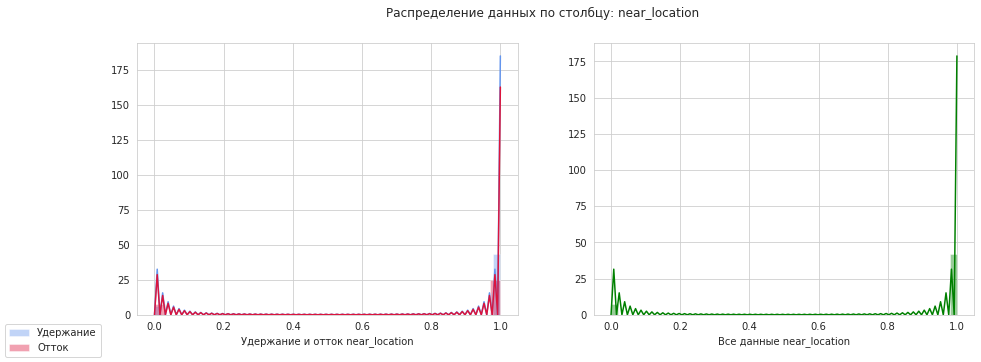

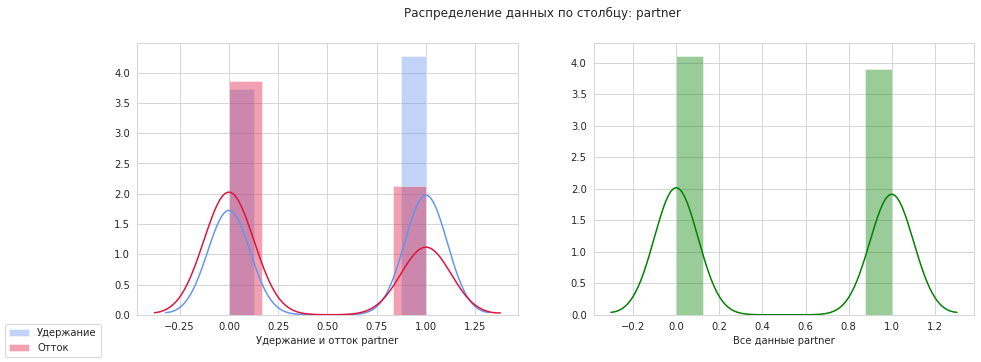

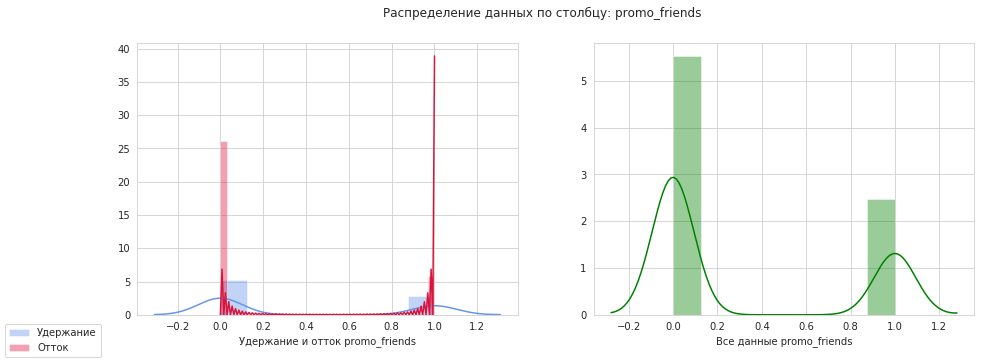

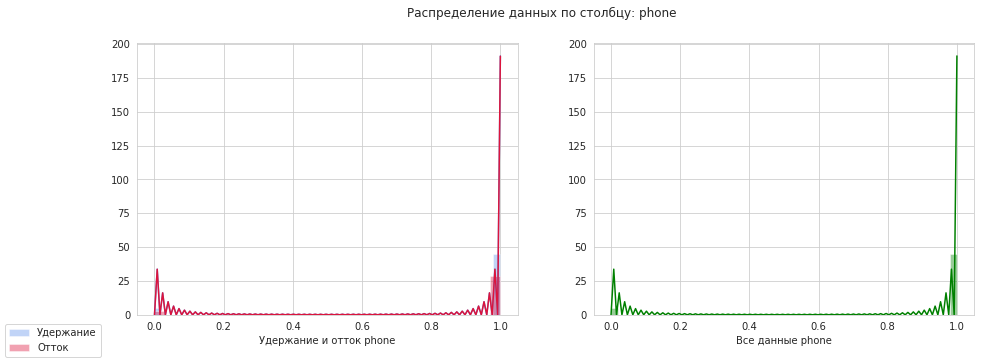

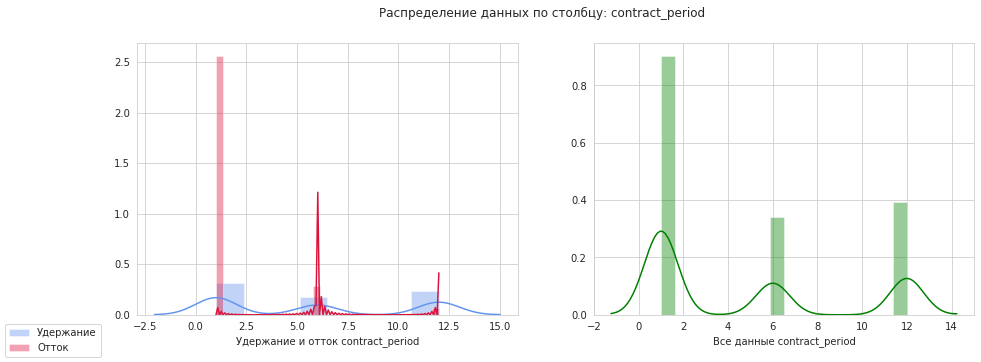

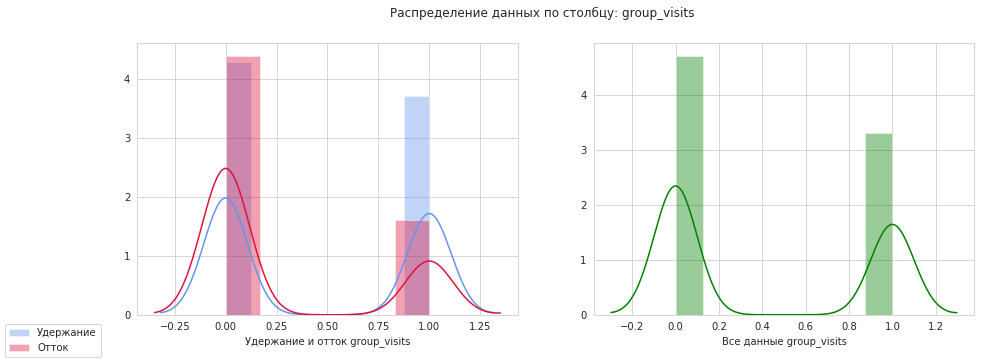

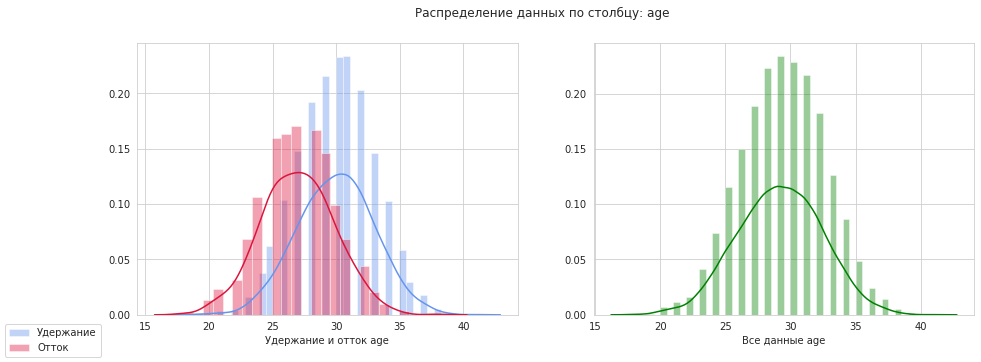

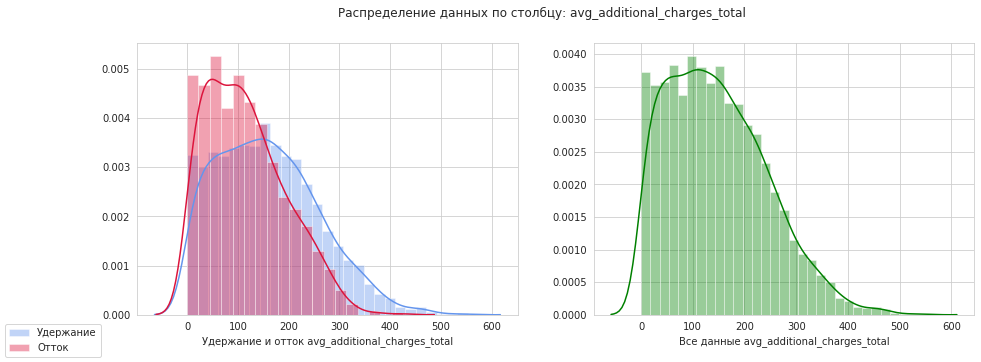

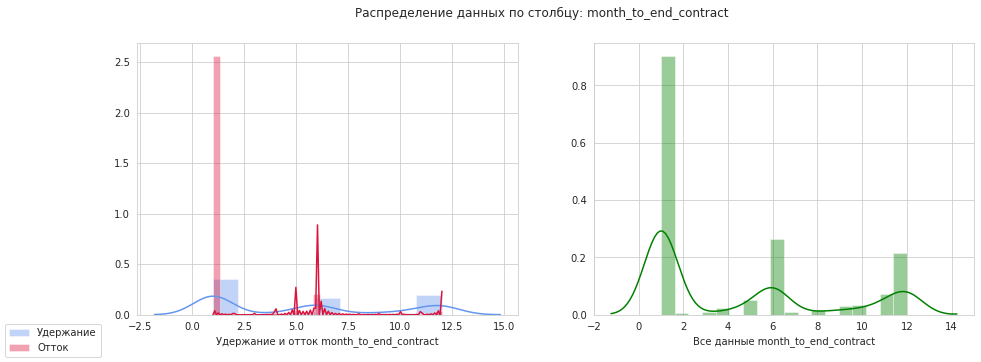

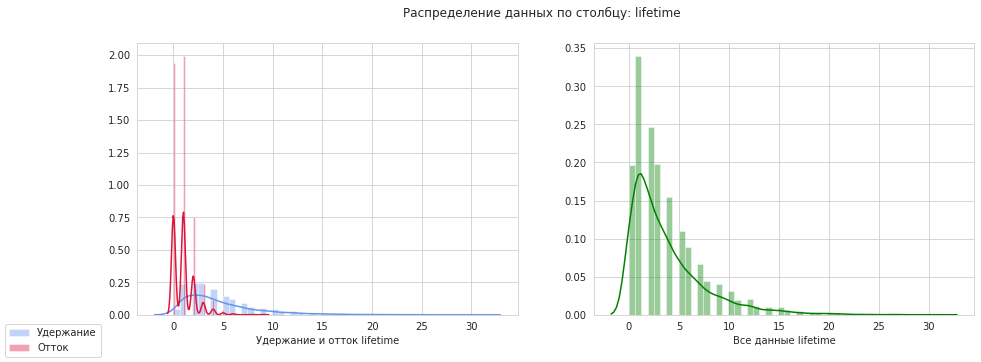

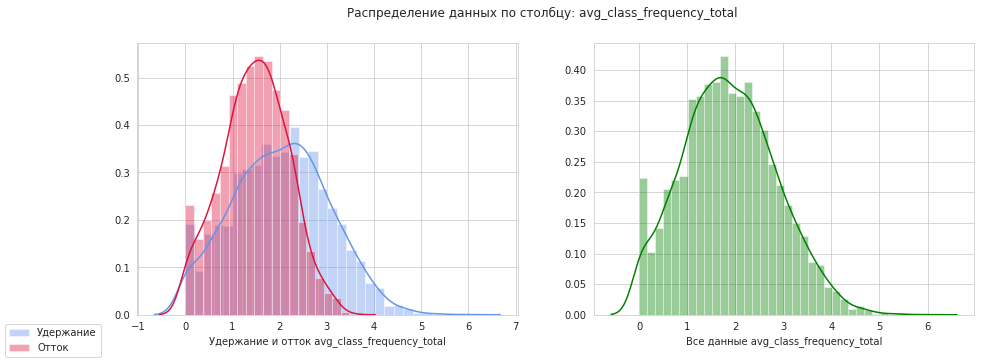

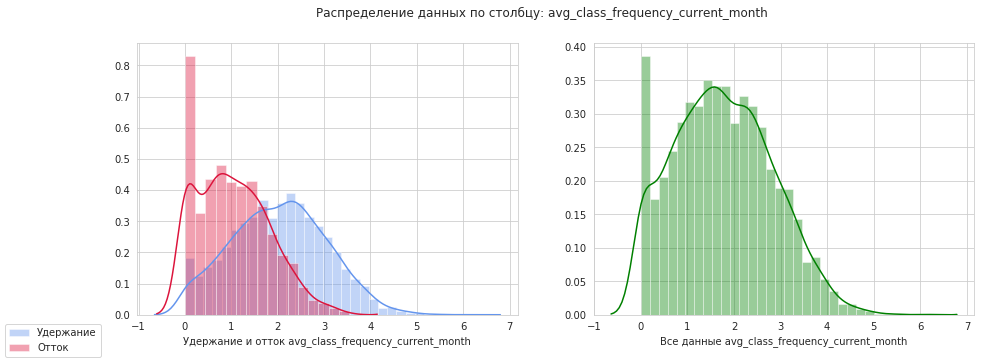

In [8]:
#посмотрим на распределение признаков
for column in gym_churn.drop('churn', axis = 1).columns:
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Распределение данных по столбцу: {}'.format(column))
    sns.distplot(gym_churn.query('churn == 0')[column], color="cornflowerblue", ax=ax[0], label='Удержание')
    sns.distplot(gym_churn.query('churn == 1')[column], color="crimson", ax=ax[0], axlabel='Удержание и отток ' + str(column), label = 'Отток')
    sns.distplot(gym_churn[column], color="g", ax=ax[1], axlabel='Все данные ' + str(column))
    fig.legend(loc='lower left')
    plt.show()

- Те, кто остались с нашим фитнес-залом в среднем ходят чаще, тратят больше на дополнительные услуги и имеют более долгосрочные контракты, чем те, кто бросил заниматься. 
- Возраст может влиять на вероятность клиента бросить занятия. Молодые люди чаще перестают ходить в зал. Это может быть связано как с недостатком финансовых средств, так и с тем фактом, что в молодом возрасте организм ещё не чувствует потребности в регулярных физических нагрузках.
- Большинство  из "оттока" бросают в первый или второй (реже третий) месяцы. Т.е. если клиент продержался 2 месяца, то можно смело предполагать, что он задержится ещё на какой-то период.

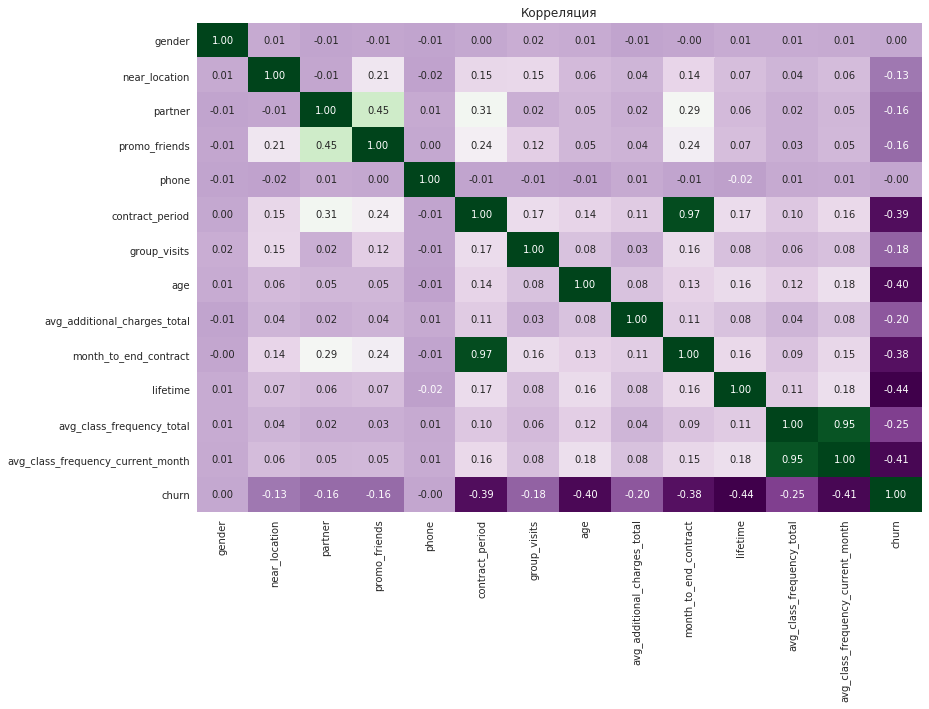

In [9]:
plt.subplots(figsize = (13, 9))
sns.heatmap(gym_churn.corr(), annot=True, fmt = '0.2f', cmap='PRGn', cbar=False)
plt.title('Корреляция')
plt.show()

Отчетливой зависимости целевой переменной (отток - churn) от какого-либо признака не выявлено. Однако сильно коррелируют: avg_class_frequency_total и avg_class_frequency_current_month - 0.95 и contract_period и month_to_end_contract - 0.97. Чтобы избавиться от мультиколлинеарности, удалим из датафрейма один из них - Avg_class_frequency_total и Month_to_end_contract.

In [10]:
gym_churn.drop('avg_class_frequency_total', axis = 1, inplace = True) 
gym_churn.drop('month_to_end_contract', axis = 1, inplace = True)

### Вывод

Данные более или менее однородны, значительных выбросов не выявлено, но все равно далее при обучении модели лучше использовать стандартизированные данные. Общий процент оттока 26.5%. К сожалению нельзя сказать, что отток клиентов однозначно зависит от какого-либо признака, матрица корреляции нам к этом плане ничего не подсказала, однако мы смогли заметить мультиколлинеальность и избавиться от неё.

## <a id="step3">Шаг 3. Модель прогнозирования оттока пользователей </a>

In [11]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
#стандатизируем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [13]:
#зададим необходимые параметры для моделей
models = [LogisticRegression(random_state = 0), RandomForestClassifier(n_estimators = 100, random_state = 0)]

In [14]:
for model in models:
    # обучим модель
    model.fit(X_train_st, y_train)
    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:,1]
    # выведем все метрики
    print(model)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('\tF1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75
	F1: 0.78
	ROC_AUC: 0.95


### Вывод

Построив модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце, мы обучили её логистической регрессией и случайным лесом. Обе модели показали хороший результат, но метрики логистической регрессии немножечко лучше. 

## <a id="step4">Шаг 4. Кластеризация пользователей </a>

In [15]:
# Стандартизируем данные перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

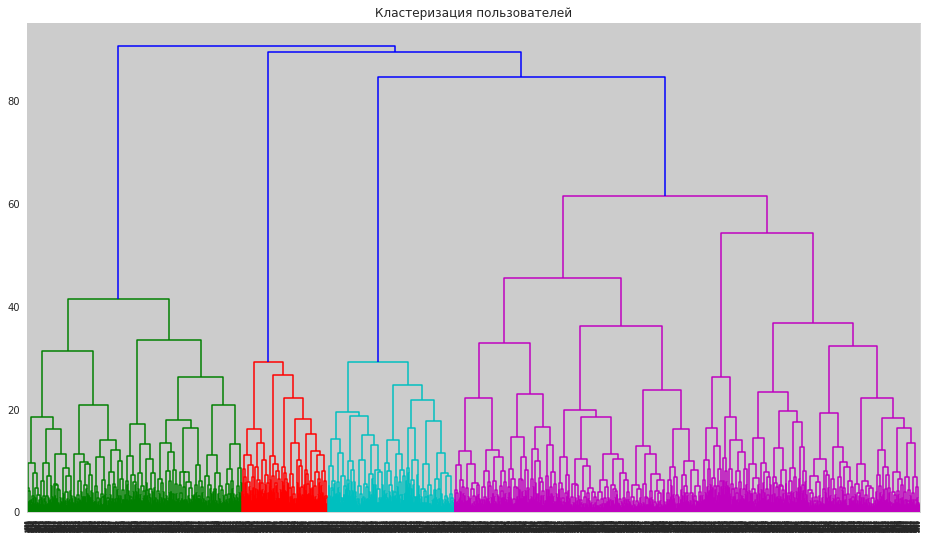

In [16]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Если смотреть на график, то хочется выделить 4 кластера, но в условях выполнения проекта указано, что их будет 5. В принципе, 5 кластеров глаз здесь тоже выделяет. 

In [17]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров
gym_churn['cluster'] = labels # сохраняем метки кластера в наш датасет

In [18]:
gym_churn['cluster'].value_counts()

2    1064
3    1007
0     985
1     558
4     386
Name: cluster, dtype: int64

In [19]:
gym_churn.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


Сразу бросатеся в глаза, что кластер 3 самый надежный. Эти клиенты дольше всех пользуются услугами фитнес-зала, стабильно посещают его больше двух раз в месяц, тратят больше всех на доплнительные услуги.

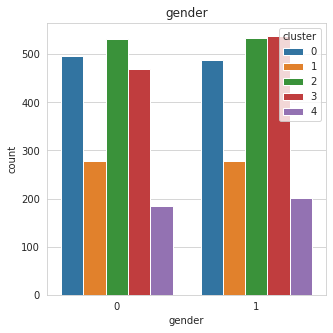

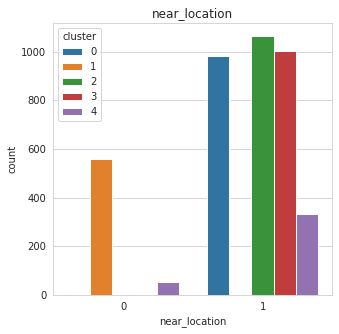

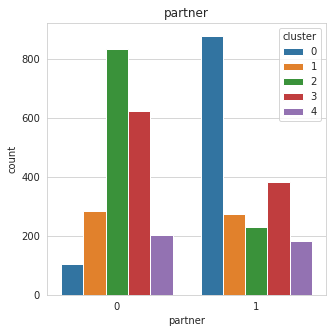

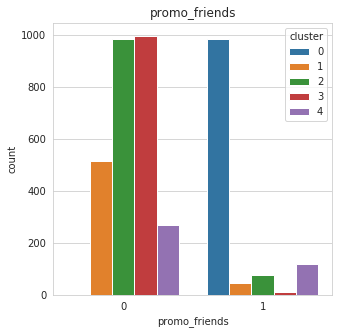

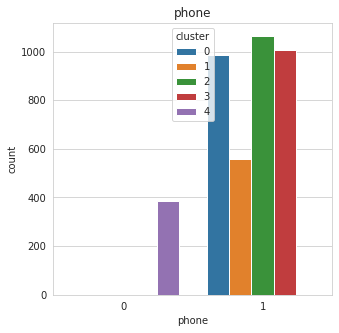

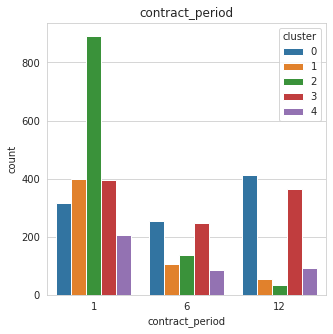

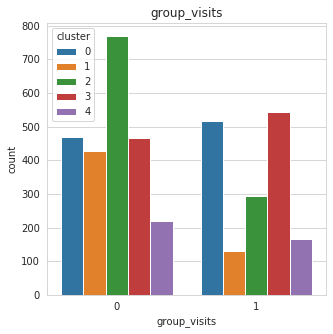

In [20]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gym_churn[column], hue='cluster', data=gym_churn)
    plt.title(column)
    plt.show()

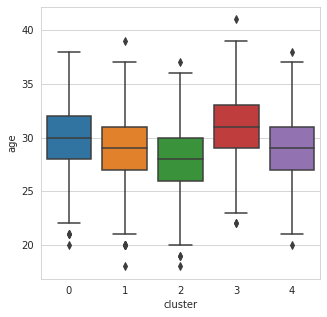

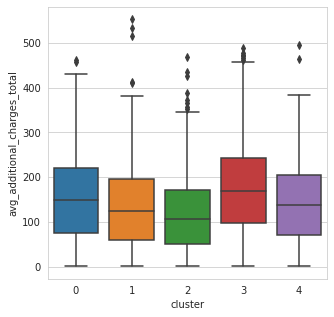

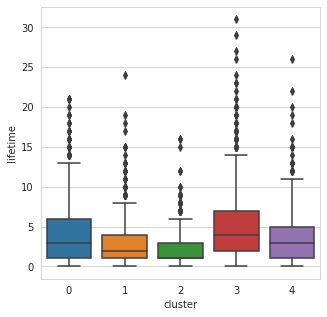

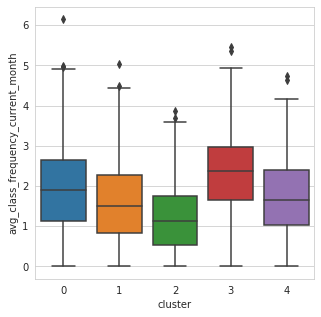

In [21]:
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster', y = gym_churn[column], data = gym_churn)
    plt.show()

In [22]:
cluster_churn_share = gym_churn.groupby('cluster')['churn'].mean().reset_index()
cluster_churn_share['churn'] = cluster_churn_share['churn'].map(lambda x: '{:.2%}'.format(x))
cluster_churn_share.sort_values('churn')

,cluster,churn
3,3,1.49%
0,0,11.98%
4,4,26.68%
1,1,40.32%
2,2,56.39%


### Вывод

Метод К-Means выделил следующие кластеры пользователей:

0) кластер клиентов, пришедших по программе "приведи друга"
  - 985 клиентов
  - отток составляет 11.98%
  - чаще других выбирают долгосрочные абонементы
  - посещают примерно два раза в месяц
  
1) кластер клиентов, не проживающих/не работающих в районе, где находится фитнес-центр
  - 558 клиентов
  - отток составляет 40.32%
  - большинство пришли по программе "приведи друга"
  - чаще всего заключают контракт на месяц
  - не очень любят ходить на групповые занятия
  - ходят реже чем, большинство остальных кластеров
  
2) кластер клиентов, с самой большой долей абонементов на 1 месяц
  - 1064 клиента
  - отток максимален 56.39%
  - находятся в том же районе, что и фитнес-центр
  - большинство не являются сотрудниками компании-партнёра клуба
  - не используют промо-код из акции "приведи друга"
  - самые низкие показатели по посещаемости
  - самые низкие показатели по признаку Lifetime
  
3) кластер клиентов, потративших больше всего денег на дополнительные услуги
  - 1007 клиентов
  - отток минимален 1.49%
  - высокие показатели посещаемости
  - большой процент долгосрочных абонементов
  - высокие показатели по признаку посещения групповых занятий
  - среди клиентов практически нет тех, кто использовал промо-код от знакомого при оплате первого абонемента
  
4) кластер клиентов, не оставивших свой номер телефона
  - 386 клиентов
  - отток составляет 26.68% 
  - распределения признаков тоже схожи с данными по всему датасету 
    

## <a id="step5">Шаг 5. Выводы и базовые рекомендации по работе с клиентами </a>

Необходимо сосредоточится на кластерах 2 и 1, так как в них почти половина клиентов бросили занятия. 

Клиенты из второго кластера как правило выбирают фитнес-центр по территриальному признаку, они не участвуют в парнерских программах и не используют промо-акцию "приведи друга". Возможно стоит разработать для них отдельную рекламную кампанию и поощерять скидками тех, кто выбирает зал поближе и ходит минимум полгода.

Клиенты из первого кластера наоборот находятся далеко от фитнес-центра и узнают о конкретном месте от друзей, пользуются скидкой по программе "приведи друга". Им во многом не хватает мотивации возвращаться из-за, того что не хочется тратить время на дорогу. Ходить с другом или знакомым за компанию всегда веселей, можно попробовать удержать этих клиентов за счёт людей, которые им изначально дали промо-код акции. Например, им можно иногда выдавать купоны на дополнительные услуги, при условии, что друзья воспользуются ими одновременно.

В любом случае самое большое внимание стоит обратить на новых клиентов, ведь большинство уходит в первые два месяца. Можно устраивать мероприятия направленные на формирование комьюнити и вовлечению в него новичков.